In [1]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV 
import optuna
import shap

/Users/ryan/Desktop/redman v2/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class_names = ["没有分数", "通过", "复测", "无法打分", "建议就医"]
column_names = [
    "result",
    "total_score",
    "baseline_score",
    "amplitude_score",
    "acceleration_during_score",
    "acceleration_amp_score",
    "fetal_count_score",
    "loss_sub_score",
    "deceleration_sub_score",
    "acceleration_count_sub_score",
    "sine_sub_score",
    "zigzag_sub_score",
    "week", #孕周
    "loss", #信号丢失率
    "during_in_s", #测试时长
    "merge_fetal_count", #合并胎动次数
    "baseline_bpm", #基线值
    "baseline_list", 
    "amplitude_10_count", #加速次数：振幅超10bpm
    "amplitude_15_count", #加速次数：振幅超15bpm
    "deceleration_count", #减速次数
    "long_term_amplitude", #长变异振幅 bpm
    "stv_abnormal_25_count", #短变异异常次数>=25 bpm
    "stv_abnormal_5_count", #短变异异常次数<5 bpm
    "stv_normal_count", #短变异正常次数
    "stv_in_ms", #短变异:平均ms
    "acc_during", #加速最大持续时长(单位秒)
    "acc_amplitude", #加速最大振幅 bpm
    "potential_dec_count", #潜在减速次数
    "is_sine", #是否正弦波
    "re_test_times" #复测次数
]
raw_dataset = pd.read_csv(
    "ai_training_data_25.csv",
    names=column_names,
    na_values="?",
    comment="\t",
    sep=",",
    skipinitialspace=True,
)

In [3]:
raw_dataset.pop('baseline_list')
raw_dataset.pop('stv_in_ms')
raw_dataset.pop('total_score')
raw_dataset.pop('baseline_score')
raw_dataset.pop('amplitude_score')
raw_dataset.pop('acceleration_during_score')
raw_dataset.pop('acceleration_amp_score')
raw_dataset.pop('fetal_count_score')
raw_dataset.pop('loss_sub_score')
raw_dataset.pop('deceleration_sub_score')
raw_dataset.pop('acceleration_count_sub_score')
raw_dataset.pop('sine_sub_score')
raw_dataset.pop('zigzag_sub_score')

raw_dataset['loss'] = raw_dataset['loss'] / 10000.0
raw_dataset['during_in_s'] = raw_dataset['during_in_s'] / 1000.0
raw_dataset['baseline_bpm'] = raw_dataset['baseline_bpm'] / 200.0
raw_dataset['long_term_amplitude'] = raw_dataset['long_term_amplitude'] / 100.0
raw_dataset['amplitude_10_count'] = raw_dataset['amplitude_10_count'] / 100.0
raw_dataset['amplitude_15_count'] = raw_dataset['amplitude_15_count'] / 100.0
raw_dataset['stv_abnormal_25_count'] = raw_dataset['stv_abnormal_25_count'] / 20.0
raw_dataset['stv_abnormal_5_count'] = raw_dataset['stv_abnormal_5_count'] / 20.0
raw_dataset['stv_normal_count'] = raw_dataset['stv_normal_count'] / 20.0
raw_dataset['merge_fetal_count'] = raw_dataset['merge_fetal_count'] / 10.0
raw_dataset['deceleration_count'] = raw_dataset['deceleration_count'] / 10.0

In [4]:
print((raw_dataset['result'] == 4).sum())
raw_dataset['result'] -= 1

6


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
      raw_dataset.drop(["result"], axis=1),
      raw_dataset["result"], 
      random_state=10, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(80000, 17) (80000,) (20000, 17) (20000,)


Accuracy: 0.9213
AUC-ROC Score: 0.9275050619002977


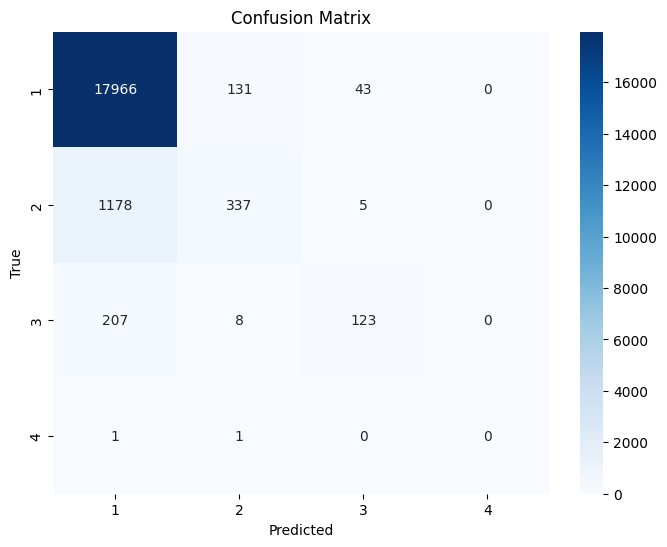

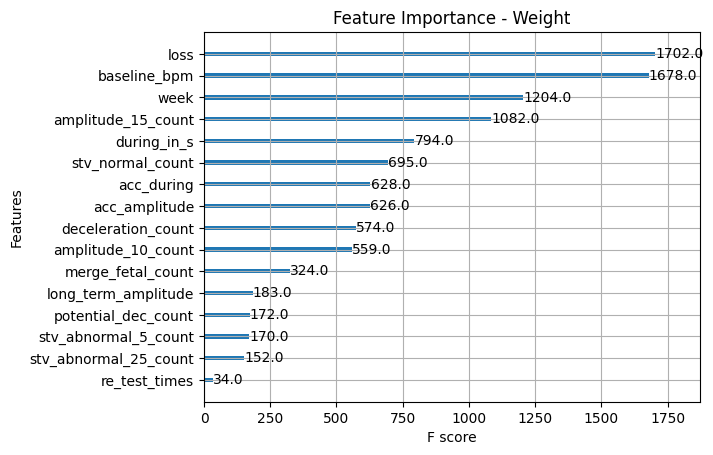

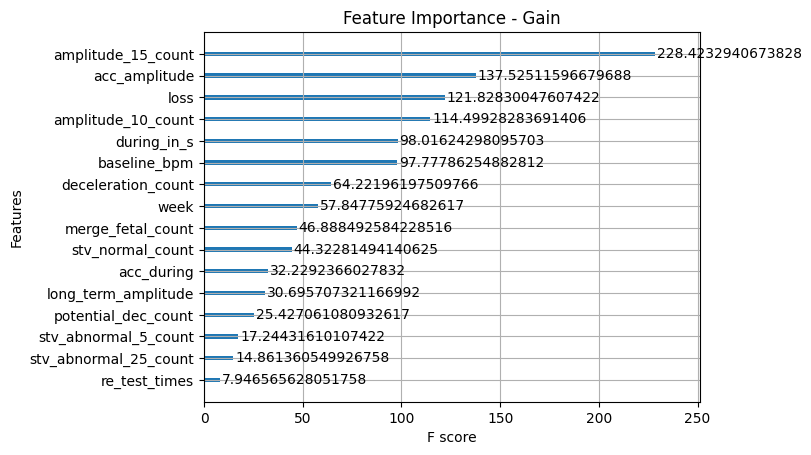

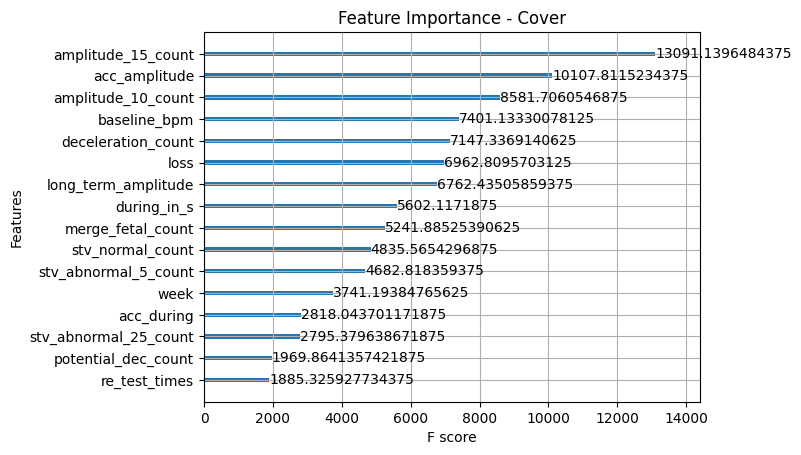

In [6]:
params = {
    "booster": "gbtree",
    "objective": "multi:softprob",
    "num_class": 4,
    "gamma": 0.1,
    "max_depth": 3,
    # 'lambda': 2,
    "subsample": 1,
    "colsample_bytree": 0.6,
    "min_child_weight": 3,
    'eta': 0.01,
    "seed": 1000,
    "nthread": 4,
}
# 封装xgboost数据集
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
# 训练轮数，即树的棵数
num_rounds = 500
# 模型训练
model_xgb = xgb.train(params, dtrain, num_rounds)

# 对测试集进行预测
y_pred = model_xgb.predict(dtest)
predictions = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

auc_roc = roc_auc_score(y_test, y_pred, multi_class="ovr")
print(f"AUC-ROC Score: {auc_roc}")

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.arange(1, 5),
    yticklabels=np.arange(1, 5),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot feature importance
xgb.plot_importance(model_xgb, importance_type="weight")
plt.title("Feature Importance - Weight")
plt.show()

xgb.plot_importance(model_xgb, importance_type="gain")
plt.title("Feature Importance - Gain")
plt.show()

xgb.plot_importance(model_xgb, importance_type="cover")
plt.title("Feature Importance - Cover")
plt.show()

In [7]:
# # Hyperparameter tuning using Bayes Optimization

# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#         params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc', "verbose": -1}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['lambda_l1'] = max(lambda_l1, 0)
#         params['lambda_l2'] = max(lambda_l2, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, metrics=['auc'])
#         return max(cv_result['valid auc-mean'])

#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'lambda_l1': (0, 5),
#                                             'lambda_l2': (0, 3),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=0)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # return best parameters
#     return lgbBO.max['params']

# opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=5, random_seed=6, n_estimators=300, learning_rate=0.01)
# opt_params['num_leaves'] = int(round(opt_params['num_leaves']))
# opt_params['max_depth'] = int(round(opt_params['max_depth']))

In [8]:
# Hyperparameter tuning using Optuna

class Objective:
    def __init__(self, X_train, y_train, X_test, y_test):
        # Hold this implementation specific arguments as the fields of the class.
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def __call__(self, trial):
        # Calculate an objective value by using the extra arguments.
        dtrain = lgb.Dataset(data=X_train, label=y_train)

        param = {
            "objective": "multiclass",
            "num_class": 4,
            "verbosity": -1,
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        gbm = lgb.train(param, dtrain, num_boost_round=trial.suggest_int("num_boost_round", 100, 500))
        y_pred = gbm.predict(X_test)
        auc_roc = roc_auc_score(y_test, y_pred, multi_class="ovr")
        return auc_roc

study = optuna.create_study(direction="maximize")
study.optimize(Objective(X_train, y_train, X_test, y_test), n_trials=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

opt_params = trial.params

[I 2024-07-17 16:33:27,359] A new study created in memory with name: no-name-e6386979-a2c0-4488-832e-30c711a2eae7
[I 2024-07-17 16:33:44,422] Trial 0 finished with value: 0.8614051277394368 and parameters: {'learning_rate': 0.03412881591446473, 'lambda_l1': 3.238800515085151e-08, 'lambda_l2': 0.04290034654542678, 'num_leaves': 106, 'feature_fraction': 0.6303493412654709, 'bagging_fraction': 0.8905076804182797, 'bagging_freq': 4, 'min_child_samples': 13, 'num_boost_round': 325}. Best is trial 0 with value: 0.8614051277394368.
[I 2024-07-17 16:33:55,129] Trial 1 finished with value: 0.863017837005408 and parameters: {'learning_rate': 0.07540890772281267, 'lambda_l1': 1.5366950315567903e-08, 'lambda_l2': 0.2845054924087995, 'num_leaves': 46, 'feature_fraction': 0.6590966511734644, 'bagging_fraction': 0.4120247278242244, 'bagging_freq': 2, 'min_child_samples': 20, 'num_boost_round': 414}. Best is trial 1 with value: 0.863017837005408.
[I 2024-07-17 16:34:11,436] Trial 2 finished with value

Number of finished trials: 5
Best trial:
  Value: 0.9019996806495402
  Params: 
    learning_rate: 0.005007499309383625
    lambda_l1: 5.80753747627777e-05
    lambda_l2: 0.5194275415829881
    num_leaves: 242
    feature_fraction: 0.4487224332701088
    bagging_fraction: 0.6193500462974942
    bagging_freq: 3
    min_child_samples: 44
    num_boost_round: 118


/Users/ryan/Desktop/redman v2/.env/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Accuracy: 0.90925
AUC-ROC Score: 0.9019996806495402


100%|===================| 19979/20000 [08:39<00:00]        

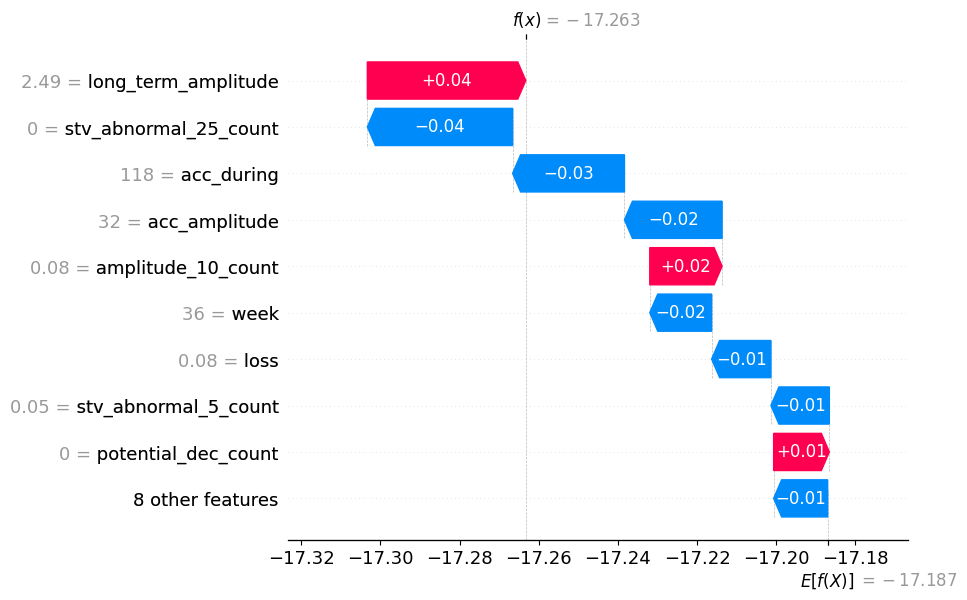

In [9]:
# lightgbm模型拟合
opt_params.update(
    {
        "objective": "multiclass",
        "num_class": 4,
        "verbosity": -1,
        "boosting_type": "gbdt",
    }
)
dtrain = lgb.Dataset(data=X_train, label=y_train)
model_lgb = lgb.train(opt_params, dtrain)
y_pred = model_lgb.predict(X_test)
predictions = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")s

auc_roc = roc_auc_score(y_test, y_pred, multi_class="ovr")
print(f"AUC-ROC Score: {auc_roc}")

explainer = shap.Explainer(model_lgb, X_train)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [18]:
shap.plots.force(shap_values[:500])

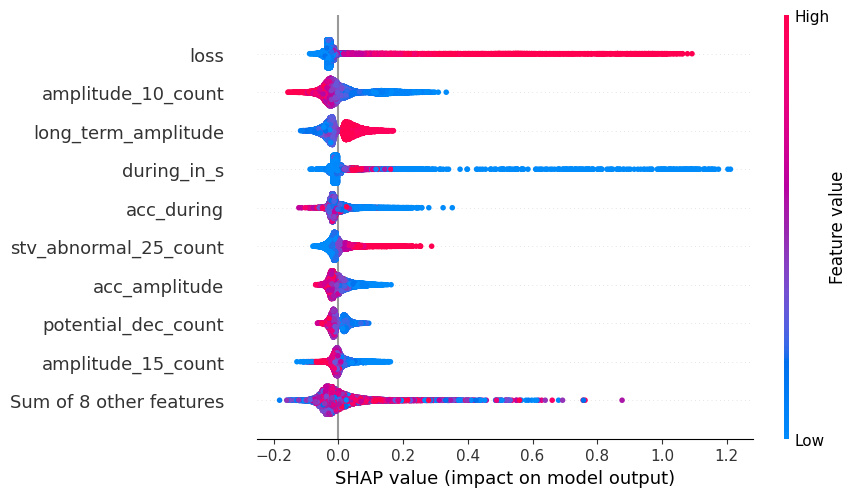

In [19]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

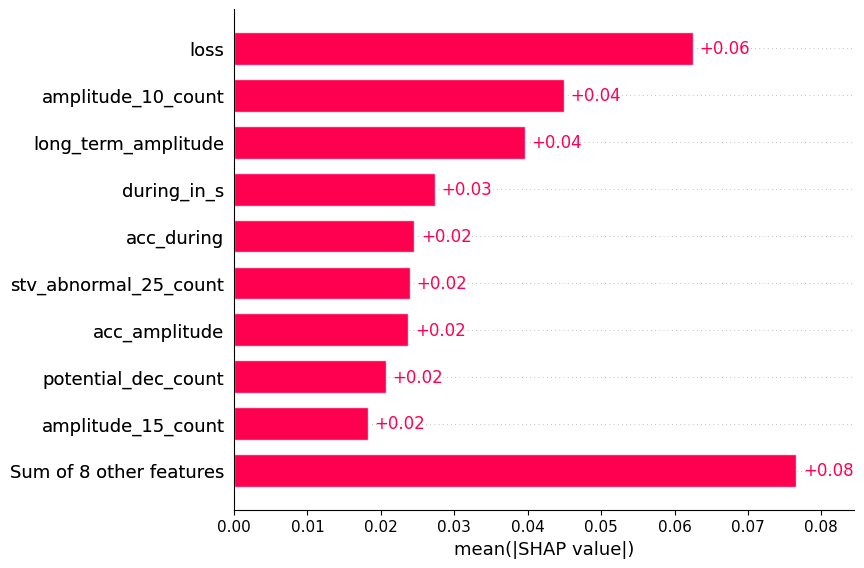

In [22]:
shap.plots.bar(shap_values)

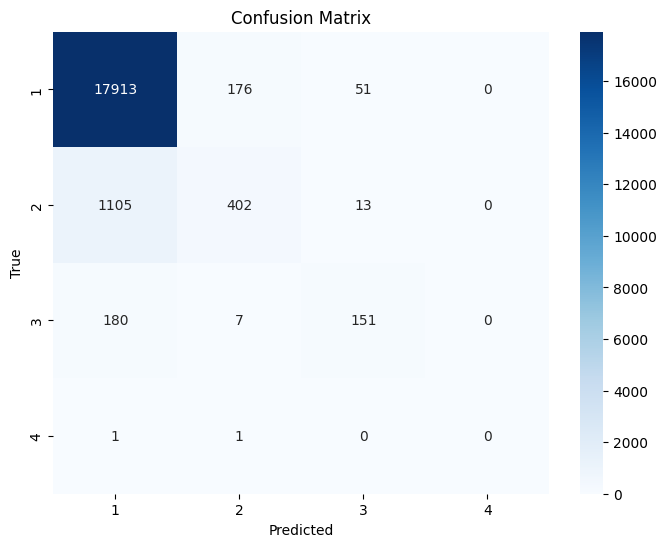

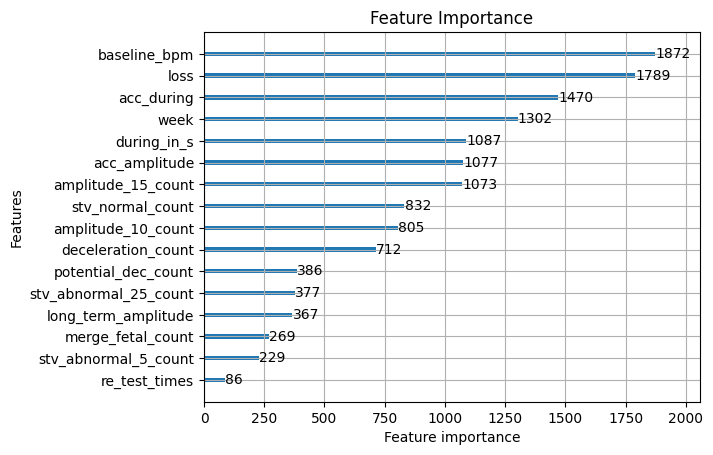

In [28]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.arange(1, 5),
    yticklabels=np.arange(1, 5),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot feature importance
lgb.plot_importance(model_lgb)
plt.title("Feature Importance")
plt.show()

Accuracy: 0.9221
AUC-ROC Score: 0.9072695616301054


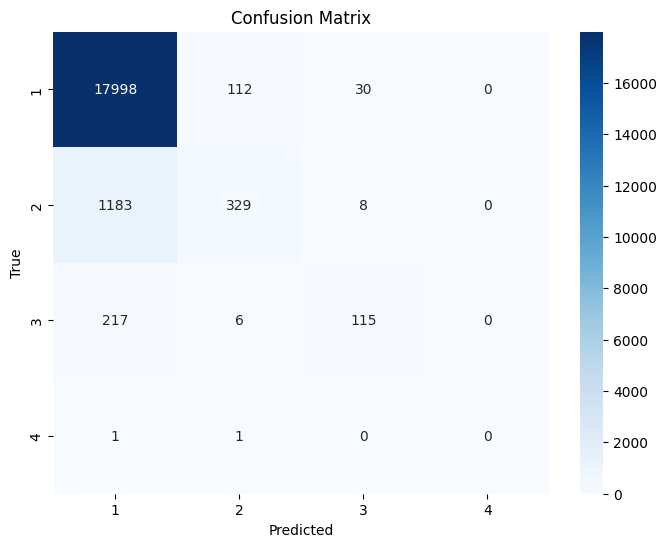

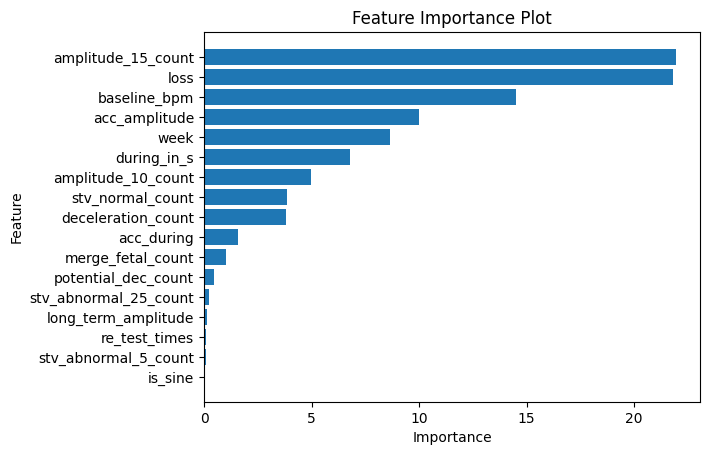

In [14]:
# 创建catboost模型实例
model_cb = cb.CatBoostClassifier(
    eval_metric="AUC",
    one_hot_max_size=50,
    depth=6,
    iterations=300,
    # l2_leaf_reg=1,
    learning_rate=0.01,
    silent=True
)
# catboost模型拟合
model_cb.fit(X_train, y_train)
# 对测试集进行预测
y_pred = model_cb.predict_proba(X_test)
predictions = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"AUC-ROC Score: {auc_roc}")

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.arange(1, 5),
    yticklabels=np.arange(1, 5),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot feature importance
feature_importances = model_cb.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()
plt.show()